In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import json
import gc
from functools import partial
from pathlib import Path

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from einops import rearrange
from scipy import ndimage

dir2 = os.path.abspath('../..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)
    
from pipeline.utils import index_unsorted, nested_insert, nested_select
from pipeline.compact_json_encoder import CompactJSONEncoder

In [2]:
midas_type = "DPT_Large" # "DPT_Large" or "DPT_Hybrid"
model = torch.hub.load("intel-isl/MiDaS", midas_type)
device = torch.device('cuda')
model.to(device)
model.eval()
transform = torch.hub.load('intel-isl/MiDaS', 'transforms').dpt_transform

Using cache found in C:\Users\Cefir/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\Cefir/.cache\torch\hub\intel-isl_MiDaS_master


In [3]:
dataset_path = Path('D:\\Datasets\\NSD\\')
stimulu_path = dataset_path / 'nsddata_stimuli' / 'stimuli' / 'nsd' / 'nsd_stimuli.hdf5'
stimulus_images = h5py.File(stimulu_path, 'r')['imgBrick']

In [4]:
N = stimulus_images.shape[0]
@interact(i=(0, N-1))
def show_depth(i):
    image = stimulus_images[i]
    x = transform(image)
    with torch.no_grad():
        depth = model(x.to(device)).cpu()
        depth = F.interpolate(depth[:, None], size=image.shape[:2], mode='bicubic', align_corners=False)
        depth = depth[0, 0].numpy()
        
    figure = plt.figure(figsize=(16, 16))
    grid = figure.add_gridspec(1, 2)
    
    image_ax = figure.add_subplot(grid[0, 0])
    image_ax.axis('off')
    
    depth_ax = figure.add_subplot(grid[0, 1])
    depth_ax.axis('off')

    image_ax.imshow(image)
    depth_ax.imshow(depth)
    plt.show()

interactive(children=(IntSlider(value=36499, description='i', max=72999), Output()), _dom_classes=('widget-int…

In [7]:
# Feature visualizer
from PIL import Image
from functools import partial

def vis_features(x):
    if not isinstance(x, torch.Tensor):
        print(type(x))
        return
    x = x.float().cpu()
    print(x.shape, x.dtype)
    if len(x.shape) == 3:
        if x.shape[1] == 577:
            x = x[:, :-1]
        D = x.shape[1]
        fract, whole = np.modf(np.sqrt(D))
        print(fract, whole)
        if fract < 1e-5:
            sqrt_D = int(whole)
            x = rearrange(x, 'n (h w) c -> n c h w', h=sqrt_D, w=sqrt_D)
    if len(x.shape) != 4:
        return
    N, C, W, H = x.shape
    
    print(x.mean(), x.std())

    @interact(i=(0, N-1), c=(0, C-1))
    def plot_feature_map(i, c):
        fig = plt.figure(figsize=(8, 8))
        plt.imshow(x[i, c].cpu(), cmap="gray")
        plt.colorbar()
        plt.show()
        plt.close(fig)


modules = dict(model.named_modules())
#print([(node, modules[node].__class__.__name__) for node in nodes if node in modules])
N = stimulus_images.shape[0]
@interact(module_name=modules.keys(), stimulus_id=(0, N-1))
def select_module(module_name, stimulus_id):
    global features
    image = stimulus_images[stimulus_id]
    x = transform(image)
    
    features = {}
    def forward_hook(module_name, module, x_in, x_out):
        features[module_name] = x_out.clone()
    
    module = modules[module_name]
    hook_handle = module.register_forward_hook(partial(forward_hook, module_name))
    
    with torch.no_grad():
        depth = model(x.to(device)).cpu()
    
    vis_features(features[module_name])

interactive(children=(Dropdown(description='module_name', options=('', 'pretrained', 'pretrained.model', 'pret…

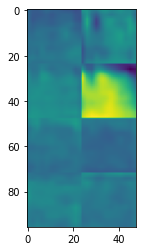

In [21]:
x = list(features.items())[0][1]
x = x[0, :8]
from einops import rearrange
x = rearrange(x, '(n1 n2) h w -> (n1 h) (n2 w )', n2=2)
x = x.cpu()
plt.imshow(x)

In [9]:
np.modf(np.sqrt(576))

(0.0, 24.0)